In [1]:
#시각화 라이브러리 설치 및 한글 폰트 설정
!pip install koreanize-matplotlib --quiet
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
koreanize_matplotlib.koreanize()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 44.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/3학년 2학기/싱가포르/data/Trade.csv')
display(df.head())

,account_id,ts,symbol,side,openclose,position_id,leverage,price,qty,amount
0,A_c668740478,2025-03-01 00:04:14.329767,BTCUSDT.PERP,LONG,OPEN,P_9ecd54214c,50,84303.5,0.177839,14992.450136
1,A_c668740478,2025-03-01 00:09:08.199617,BTCUSDT.PERP,LONG,CLOSE,P_9ecd54214c,0,84321.0,0.177839,14995.562319
2,A_7e27164ab6,2025-03-01 00:23:25.371503,BTCUSDT.PERP,LONG,OPEN,P_fbe21fd2c4,2,84369.2,0.002787,235.136960
3,A_c668740478,2025-03-01 00:30:03.218306,BTCUSDT.PERP,LONG,OPEN,P_9567d3d1d3,50,84243.3,0.178533,15040.209079
4,A_c668740478,2025-03-01 00:34:38.392647,BTCUSDT.PERP,LONG,CLOSE,P_9567d3d1d3,0,84121.0,0.178533,15018.374493


In [5]:

df['ts']=pd.to_datetime(df['ts'])
df=df.sort_values('ts')

window=pd.Timedelta(milliseconds=500)
pairs=set()

for symbol, d in df.groupby("symbol"):
    d=d.sort_values('ts')
    for i in range(len(d)):
        for j in range(i+1,len(d)):
            if d['ts'].iloc[j]-d['ts'].iloc[i] > window:
                break
            # same symbol (grouped), equal amount, equal leverage, different accounts
            if (
                abs(d['amount'].iloc[i] - d['amount'].iloc[j]) < 1e-6
                and d['leverage'].iloc[i] == d['leverage'].iloc[j]
                and d['account_id'].iloc[i] != d['account_id'].iloc[j]
            ):
                pairs.add((d['position_id'].iloc[i], d['position_id'].iloc[j]))

len_pairs = len(pairs)
pos_involved = set([p for pair in pairs for p in pair])
acc_involved = df[df['position_id'].isin(pos_involved)]["account_id"].unique()

len_pairs, len(acc_involved)


(145, 8)

In [11]:
df['ts'] = pd.to_datetime(df['ts'])
df = df.sort_values('ts')

# New condition:
# - same symbol
# - same qty
# - same leverage
# - abs(time diff) <= 0.01s (10ms)
# - different accounts
# (amount condition removed)

window = pd.Timedelta(milliseconds=10)
pairs = set()

for symbol, d in df.groupby("symbol"):
    d = d.sort_values('ts')

    ts  = d['ts'].values
    qty = d['qty'].values
    lev = d['leverage'].values
    acc = d['account_id'].values
    pos = d['position_id'].values

    for i in range(len(d)):
        for j in range(i+1, len(d)):
            if ts[j] - ts[i] > window:
                break

            # matching criteria
            if (
                abs(qty[i] - qty[j]) < 1e-9 and
                lev[i] == lev[j] and
                acc[i] != acc[j]
            ):
                pairs.add(pos[i])
                pairs.add(pos[j])

# Suspicious positions
sus_positions = list(pairs)

# Extract accounts involved
sus_accounts = df[df["position_id"].isin(sus_positions)]["account_id"].unique()

(len(sus_positions), len(sus_accounts), sus_accounts[:20])


(76,
 6,
 array(['A_dcd87c6c96', 'A_e7205c325a', 'A_4943ad62b4', 'A_e27beda014',
        'A_f96ede8d34', 'A_d444580218'], dtype=object))

In [8]:
df['ts'] = pd.to_datetime(df['ts'])
df = df.sort_values('ts')

# Identify suspicious pairs with 0.01s window and identical amount, leverage, qty, symbol
window = pd.Timedelta(milliseconds=10)
pairs = set()

for symbol, d in df.groupby("symbol"):
    d = d.sort_values('ts')
    ts = d['ts'].values
    amt = d['amount'].values
    lev = d['leverage'].values
    qty = d['qty'].values
    acc = d['account_id'].values
    pos = d['position_id'].values

    for i in range(len(d)):
        for j in range(i+1, len(d)):
            if ts[j] - ts[i] > window:
                break
            if (
                abs(amt[i] - amt[j]) < 1e-6 and
                lev[i] == lev[j] and
                abs(qty[i] - qty[j]) < 1e-9 and
                acc[i] != acc[j]
            ):
                pairs.add(pos[i])
                pairs.add(pos[j])

# Keep only unique suspicious positions
sus_positions = list(pairs)

# Compute PnL per position
opens = df[df['openclose']=="OPEN"].groupby("position_id").first()
closes = df[df['openclose']=="CLOSE"].groupby("position_id").first()

records = []
for pid in sus_positions:
    if pid in opens.index and pid in closes.index:
        o = opens.loc[pid]
        c = closes.loc[pid]

        side = o["side"]
        qty = o["qty"]
        pnl = (c["price"] - o["price"]) * qty if side == "LONG" else (o["price"] - c["price"]) * qty

        records.append({
            "account_id": o["account_id"],
            "position_id": pid,
            "symbol": o["symbol"],
            "open_price": o["price"],
            "close_price": c["price"],
            "qty": qty,
            "pnl": pnl
        })

pnl_df = pd.DataFrame(records)

# Aggregate PnL per account
summary = pnl_df.groupby("account_id")["pnl"].sum().reset_index().sort_values("pnl", ascending=False)

summary


,account_id,pnl
0,A_4943ad62b4,-3.513417
3,A_e27beda014,-3.513417
4,A_e7205c325a,-54.283069
2,A_dcd87c6c96,-54.283069
1,A_d444580218,-531.439367
5,A_f96ede8d34,-635.866241


In [9]:
# import pandas as pd

# Load data
# df = pd.read_csv("/mnt/data/Trade.csv")
df['ts'] = pd.to_datetime(df['ts'])

# Identify suspicious accounts previously found (hardcode from previous output)
sus_accounts = ["A_4943ad62b4","A_e27beda014","A_dcd87c6c96",
                "A_e7205c325a","A_d444580218","A_f96ede8d34"]

# Compute PnL for ALL positions
opens = df[df['openclose']=="OPEN"].groupby("position_id").first()
closes = df[df['openclose']=="CLOSE"].groupby("position_id").first()

records = []
for pid in opens.index:
    if pid in closes.index:
        o = opens.loc[pid]
        c = closes.loc[pid]
        side = o["side"]
        qty  = o["qty"]
        pnl  = (c["price"] - o["price"]) * qty if side=="LONG" else (o["price"] - c["price"]) * qty

        records.append({
            "account_id": o["account_id"],
            "position_id": pid,
            "symbol": o["symbol"],
            "open_price": o["price"],
            "close_price": c["price"],
            "qty": qty,
            "pnl": pnl
        })

all_pnl_df = pd.DataFrame(records)

# Extract only suspicious accounts full-period PnL
summary_all = all_pnl_df[all_pnl_df["account_id"].isin(sus_accounts)] \
    .groupby("account_id")["pnl"].sum().reset_index()

summary_all


,account_id,pnl
0,A_4943ad62b4,-655.475214
1,A_d444580218,-5355.090778
2,A_dcd87c6c96,-19641.191887
3,A_e27beda014,-530.106759
4,A_e7205c325a,4748.214213
5,A_f96ede8d34,-7000.544166


In [10]:
df['ts'] = pd.to_datetime(df['ts'])

# Suspicious loss accounts (5 accounts, excluding the profit one A_e7205c325a)
loss_accounts = ["A_4943ad62b4","A_e27beda014","A_dcd87c6c96",
                 "A_d444580218","A_f96ede8d34"]

# Compute trade volume per account (use "amount" column as volume proxy)
volume_per_account = df.groupby("account_id")["amount"].sum().reset_index()
volume_per_account = volume_per_account.sort_values("amount", ascending=False)

# Extract suspicious loss accounts
loss_volume = volume_per_account[volume_per_account["account_id"].isin(loss_accounts)]

# Compute descriptive stats for non-suspicious accounts
normal_volume = volume_per_account[~volume_per_account["account_id"].isin(loss_accounts)]

loss_volume, normal_volume.describe()


(      account_id        amount
 54  A_dcd87c6c96  5.724894e+07
 62  A_f96ede8d34  1.360494e+07
 52  A_d444580218  1.003083e+07
 20  A_4943ad62b4  4.293351e+06
 55  A_e27beda014  3.080857e+06,
              amount
 count  5.800000e+01
 mean   2.953613e+07
 std    7.225611e+07
 min    7.828259e+03
 25%    3.236893e+05
 50%    6.061603e+06
 75%    2.508147e+07
 max    4.165671e+08)

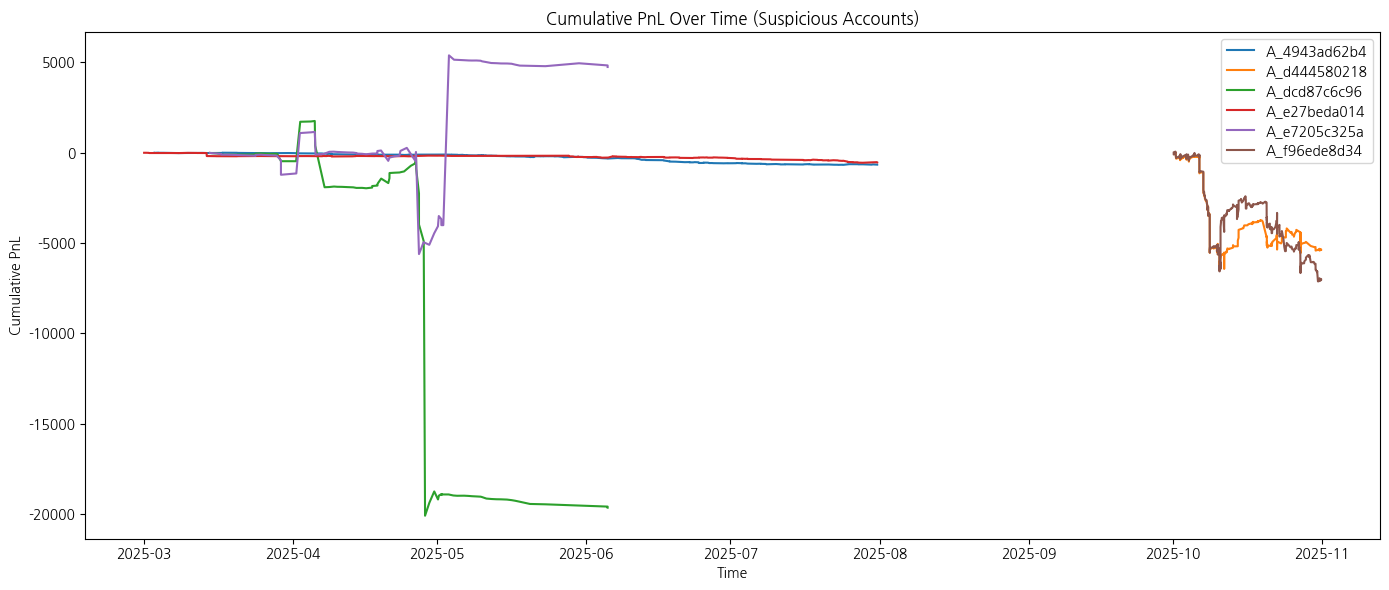

In [12]:
df = df.sort_values('ts')

# Suspicious accounts (loss accounts + profit account)
sus_accounts = ["A_dcd87c6c96","A_e7205c325a","A_4943ad62b4",
                "A_e27beda014","A_f96ede8d34","A_d444580218"]

# Compute PnL for all positions
opens = df[df['openclose']=="OPEN"].groupby("position_id").first()
closes = df[df['openclose']=="CLOSE"].groupby("position_id").first()

records = []
for pid in opens.index:
    if pid in closes.index:
        o = opens.loc[pid]
        c = closes.loc[pid]
        side = o["side"]
        qty  = o["qty"]
        pnl  = (c["price"] - o["price"]) * qty if side=="LONG" else (o["price"] - c["price"]) * qty

        records.append({
            "account_id": o["account_id"],
            "position_id": pid,
            "ts": c["ts"],  # use close timestamp for PnL realization
            "pnl": pnl
        })

pnl_df = pd.DataFrame(records)
pnl_df = pnl_df[pnl_df["account_id"].isin(sus_accounts)]
pnl_df = pnl_df.sort_values("ts")

# Compute cumulative pnl per account
cum_pnl = []
for acc, group in pnl_df.groupby("account_id"):
    g = group.sort_values("ts")
    g["cum_pnl"] = g["pnl"].cumsum()
    cum_pnl.append(g)

cum_pnl_df = pd.concat(cum_pnl)

# Plot cumulative pnl
plt.figure(figsize=(14,6))

for acc, g in cum_pnl_df.groupby("account_id"):
    plt.plot(g["ts"], g["cum_pnl"], label=acc)

plt.title("Cumulative PnL Over Time (Suspicious Accounts)")
plt.xlabel("Time")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.tight_layout()
